In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-books-dataset/Amazon_Books_Scraping/Genre_df.csv
/kaggle/input/amazon-books-dataset/Amazon_Books_Scraping/Books_df.csv
/kaggle/input/amazon-books-dataset/Amazon_Books_Scraping/Sub_Genre_df.csv


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
     

In [3]:
books = pd.read_csv('/kaggle/input/amazon-books-dataset/Amazon_Books_Scraping/Books_df.csv')
genre = pd.read_csv('/kaggle/input/amazon-books-dataset/Amazon_Books_Scraping/Genre_df.csv')
sub_genre = pd.read_csv('/kaggle/input/amazon-books-dataset/Amazon_Books_Scraping/Sub_Genre_df.csv')

In [4]:
books.drop(['Unnamed: 0'], axis=1,inplace = True)

In [5]:
genre.columns

Index(['Title', 'Number of Sub-genres', 'URL'], dtype='object')

In [6]:
# Join df1 and df2 on different columns
merged_df = pd.merge(books, genre, left_on='Main Genre', right_on='Title', how='inner')
# merged_df.head(10)
# # # Join the resulting DataFrame with df3 on another column
final_df = pd.merge(merged_df, sub_genre, left_on='Sub Genre', right_on='Title', how='inner')


#   Data Pre-Processing

In [7]:
final_df.drop(['Title_y','Number of Sub-genres','Title','Main Genre_y','URLs_y','No. of Books'],axis =1,inplace=True)

In [8]:
column_mapping = {'Title_x': 'Book_Title',
                  'Main Genre_x': 'Main Genre',
                  'URLs_x': 'Book_URL',
                 'URL': 'Genre_URL'
                 }
final_df.rename(columns = column_mapping, inplace =True)

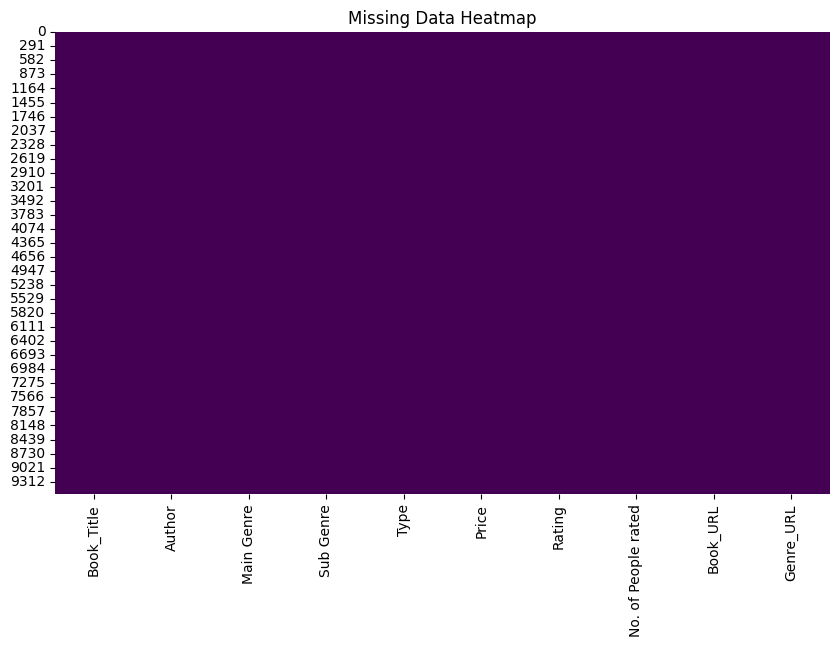

In [9]:
# Check for missing data using heatmap. Looks like we are good to go with missing data handling
missing_data = final_df.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(final_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


In [10]:
# Remove currency symbol from 'Price' and convert to float
final_df['Price'] = final_df['Price'].str.replace('₹', '').str.replace(',', '').astype(float)

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9574 entries, 0 to 9573
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           9574 non-null   object 
 1   Author               9549 non-null   object 
 2   Main Genre           9574 non-null   object 
 3   Sub Genre            9574 non-null   object 
 4   Type                 9574 non-null   object 
 5   Price                9574 non-null   float64
 6   Rating               9574 non-null   float64
 7   No. of People rated  9574 non-null   float64
 8   Book_URL             9574 non-null   object 
 9   Genre_URL            9574 non-null   object 
dtypes: float64(3), object(7)
memory usage: 748.1+ KB


# Recommendation Model Code

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from fuzzywuzzy import process
# Feature Engineering
# Concatenate relevant text features into one feature
final_df['combined_features'] = final_df['Main Genre'] + ' ' + final_df['Sub Genre'] + ' ' + final_df['Type']

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(final_df['combined_features'])

# Compute similarity scores
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
data = final_df 
# Function to recommend books based on rating, number of people rated, and free text input
def recommend_books(text_input, cosine_sim=cosine_sim):
    # Check if the text input matches exactly with any book title
    exact_match = data[data['Book_Title'].str.lower() == text_input.lower()]
    if not exact_match.empty:
        idx = exact_match.index[0]
    else:
        # If no exact match, use fuzzy string matching to find near matches
        matches = process.extract(text_input, data['Book_Title'], limit=1)
        closest_match = matches[0]
        idx = data[data['Book_Title'] == closest_match[0]].index[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: (x[1], data['Rating'].iloc[x[0]], data['No. of People rated'].iloc[x[0]]), reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 similar books
    book_indices = [i[0] for i in sim_scores]
    recommended_titles = data['Book_Title'].iloc[book_indices]
    recommended_genres = data['combined_features'].iloc[book_indices]
    return recommended_titles, recommended_genres

# Example recommendation
recommendations, recommended_genres = recommend_books("space")
print("Recommended Titles:")
print(recommendations)
print("\nCombined Genres:")
print(recommended_genres)

Recommended Titles:
732                                                                                                    The Hundred Dresses
746    George and the Unbreakable Code (Book 4) (George's Secret Key to the Universe) [Paperback] Lucy and Stephen Hawking
737                                                                                                    How To Catch A Star
717                                                                                         Time Travelling with a Hamster
735                                                                                    George's Secret Key to the Universe
744              There’s No Place Like Space!: All about our SOLAR SYSTEM.: Book 7 (The Cat in the Hat’s Learning Library)
700                                                                                            The Kid Who Came From Space
708               Progress In Computer Science With Python Textbook & Practical Book For Class 12 [Paperback] Sumita Ar